In [20]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
workspace_root = Path().cwd()
sys.path.insert(0, str(workspace_root / 'src'))

# Thesis pipeline utilities
from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet
from thesis_pipeline.topics.stm_utils import fit_topic_model, select_optimal_k, TopicModelResults

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


## 1. Load Thread Pseudo-Documents

Load the prepared thread pseudo-documents from notebook 14.

In [21]:
# Paths
input_path = get_data_path('qa', 'reddit')
output_path = get_data_path('topics', 'reddit', create=True)

print(f"Input: {input_path}")
print(f"Output: {output_path}")

Input: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/03_qa/reddit
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit


In [22]:
# Load thread pseudo-documents
thread_docs = read_parquet(input_path / 'thread_pseudodocs.parquet')

print(f"Loaded {len(thread_docs):,} thread pseudo-documents")
print(f"Columns: {thread_docs.columns.tolist()}")
print(f"\nText statistics:")
print(f"  Mean length: {thread_docs['pseudodoc_length'].mean():,.0f} chars")
print(f"  Mean tokens: {thread_docs['pseudodoc_tokens_approx'].mean():,.0f}")
print(f"  Mean comments/thread: {thread_docs['n_comments'].mean():.1f}")

Loaded 433,973 thread pseudo-documents
Columns: ['submission_id', 'title', 'selftext', 'n_comments', 'pseudodoc_text', 'pseudodoc_length', 'pseudodoc_tokens_approx', 'title_length', 'selftext_length', 'created_utc', 'subreddit', 'subreddit_id']

Text statistics:
  Mean length: 4,229 chars
  Mean tokens: 709
  Mean comments/thread: 19.6


## 2. Model Parameters

**Fixed K = 25** based on political science best practices:

- Roberts et al. (2014): K=20-30 for political textThis ensures consistent topic spaces for longitudinal comparison across quarters.

- Chang et al. (2009): K=20-30 optimal for human interpretation

- Grimmer & Stewart (2013): Consistency across periods matters more than per-period optimization- See `docs/topic_modeling_strategy.md` for full justification

In [23]:
# Model parameters
N_TOPICS = 25  # Fixed K per political science standards
RANDOM_STATE = 73  # For reproducibility
MAX_ITER = 200
MAX_FEATURES = 5000
MIN_DF = 5
MAX_DF = 0.5

print("="*60)
print("TOPIC MODEL CONFIGURATION")
print("="*60)
print(f"Number of topics: {N_TOPICS}")
print(f"Algorithm: NMF")
print(f"Max features: {MAX_FEATURES}")
print(f"Min DF: {MIN_DF}")
print(f"Max DF: {MAX_DF}")
print(f"Max iterations: {MAX_ITER}")
print(f"Random state: {RANDOM_STATE}")
print(f"\nSee docs/topic_modeling_strategy.md for K=25 justification")
print("="*60)

TOPIC MODEL CONFIGURATION
Number of topics: 25
Algorithm: NMF
Max features: 5000
Min DF: 5
Max DF: 0.5
Max iterations: 200
Random state: 73

See docs/topic_modeling_strategy.md for K=25 justification


## 3. Fit Topic Model

Fit the NMF topic model with K=25 topics.

In [24]:
# Fit topic model using thesis_pipeline utilities
print(f"Fitting topic model with K={N_TOPICS}...")
print(f"  Documents: {len(thread_docs):,}")
print(f"  Algorithm: NMF")
print(f"  Max features: {MAX_FEATURES}")

topic_model = fit_topic_model(
    documents=thread_docs['pseudodoc_text'].tolist(),
    n_topics=N_TOPICS,
    method='nmf',
    max_features=MAX_FEATURES,
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE,
    verbose=0
)

# Get document-topic distributions
doc_topic_dist = topic_model.theta

print(f"\n✓ Model fitted successfully")
print(f"  Document-topic distribution shape: {doc_topic_dist.shape}")
print(f"  Mean doc-topic weight: {doc_topic_dist.mean():.4f}")
print(f"  Iterations: {topic_model.model.n_iter_}")
print(f"  Reconstruction error: {topic_model.model.reconstruction_err_:.2f}")

Fitting topic model with K=25...
  Documents: 433,973
  Algorithm: NMF
  Max features: 5000
Fitting NMF with 25 topics on 433973 documents...
  Vocabulary size: 5000
  Document-term matrix: (433973, 5000)
  ✓ Model fitted
  Document-topic matrix (theta): (433973, 25)

✓ Model fitted successfully
  Document-topic distribution shape: (433973, 25)
  Mean doc-topic weight: 0.0400
  Iterations: 167
  Reconstruction error: 614.33


## 4. Extract and Display Topics

Extract top words for each topic and display results.

In [25]:
# Extract topics using the TopicModelResults interface
n_top_words = 15

# Display all topics
print("="*80)
print(f"TOP {n_top_words} WORDS PER TOPIC")
print("="*80)

for topic_idx in range(N_TOPICS):
    top_words = topic_model.get_top_terms(topic_idx, n_terms=n_top_words)
    words_str = ", ".join([word for word, _ in top_words[:10]])
    print(f"\nTopic {topic_idx:2d}: {words_str}")

TOP 15 WORDS PER TOPIC

Topic  0: like, just, don, know, think, really, shit, time, right, good

Topic  1: politics, submission, removal, www reddit, reddit com, message, com politics, reddit, regarding removal, question regarding

Topic  2: trump, supporters, campaign, trump supporters, media, win, gop, said, president, trump campaign

Topic  3: youtube, watch, youtube com, www youtube, com watch, https www, https, www, com, youtu

Topic  4: hillary, hillary clinton, crooked, crooked hillary, health, huma, hillary campaign, pneumonia, prison, hillary supporters

Topic  5: vote, voting, election, polls, poll, party, voter, state, win, votes

Topic  6: pepe, price, sli, sli mg, mg, https sli, buy, price pepe, wd99r, gigwt

Topic  7: wikileaks, emails, podesta, podesta emails, wikileaks org, email, emailid, org podesta, emails emailid, https wikileaks

Topic  8: deleted, maga, post, fuck, lol, ctr, centipedes, shit, new, kek

Topic  9: mph, train, speed, trump train, bot, 000 mph, viewfo

In [26]:
# Get topic descriptors
topic_descriptors_df = topic_model.get_all_topic_descriptors(n_terms=n_top_words)

# Add additional statistics
topic_summaries = []
for topic_idx in range(N_TOPICS):
    # Get top documents for this topic
    top_doc_indices = doc_topic_dist[:, topic_idx].argsort()[-5:][::-1]
    top_document_ids = [thread_docs.iloc[i]['submission_id'] for i in top_doc_indices]
    
    # Convert to int (from base-36 string)
    try:
        top_document_ids = [int(sid, 36) for sid in top_document_ids]
    except:
        # If conversion fails, keep as strings
        pass
    
    topic_summaries.append({
        'topic_id': topic_idx,
        'top_words': topic_descriptors_df.iloc[topic_idx]['top_terms'],
        'top_words_str': topic_descriptors_df.iloc[topic_idx]['top_terms_str'],
        'word_weights': topic_descriptors_df.iloc[topic_idx]['top_weights'],
        'n_documents': int((doc_topic_dist[:, topic_idx] > 0.1).sum()),
        'mean_weight': float(doc_topic_dist[:, topic_idx].mean()),
        'top_document_ids': top_document_ids
    })

print(f"\n✓ Created summaries for {len(topic_summaries)} topics")


✓ Created summaries for 25 topics


## 5. Document Assignment and Topic Quality

Assign dominant topics to documents and check topic assignments.

In [27]:
# Get dominant topic for each document
dominant_topics = doc_topic_dist.argmax(axis=1)
dominant_topic_weights = doc_topic_dist.max(axis=1)

# Add to dataframe
thread_docs['dominant_topic'] = dominant_topics
thread_docs['dominant_topic_weight'] = dominant_topic_weights

print("Document-topic assignment:")
print(f"  Mean dominant topic weight: {dominant_topic_weights.mean():.3f}")
print(f"  Median dominant topic weight: {np.median(dominant_topic_weights):.3f}")
print(f"\nDocuments per topic:")
print(thread_docs['dominant_topic'].value_counts().sort_index())

Document-topic assignment:
  Mean dominant topic weight: 0.427
  Median dominant topic weight: 0.390

Documents per topic:
dominant_topic
0     42901
1     10921
2     35947
3      9494
4     22009
5     18045
6      8517
7      7322
8     17800
9      5720
10    26946
11    19685
12    14033
13    14536
14     6510
15    17813
16    10241
17    15606
18    17466
19    12435
20    17830
21    24254
22    14244
23    33140
24    10558
Name: count, dtype: int64


## 6. Topic Distribution Analysis

In [28]:
# Topic distribution over time
thread_docs['date'] = pd.to_datetime(thread_docs['created_utc'], unit='s')
thread_docs['date_only'] = thread_docs['date'].dt.date

# Count documents per topic per day
topic_time = thread_docs.groupby(['date_only', 'dominant_topic']).size().reset_index(name='count')

print(f"Topic distribution over {thread_docs['date_only'].nunique()} days")
print(f"Date range: {thread_docs['date_only'].min()} to {thread_docs['date_only'].max()}")

Topic distribution over 61 days
Date range: 2016-09-01 to 2016-10-31


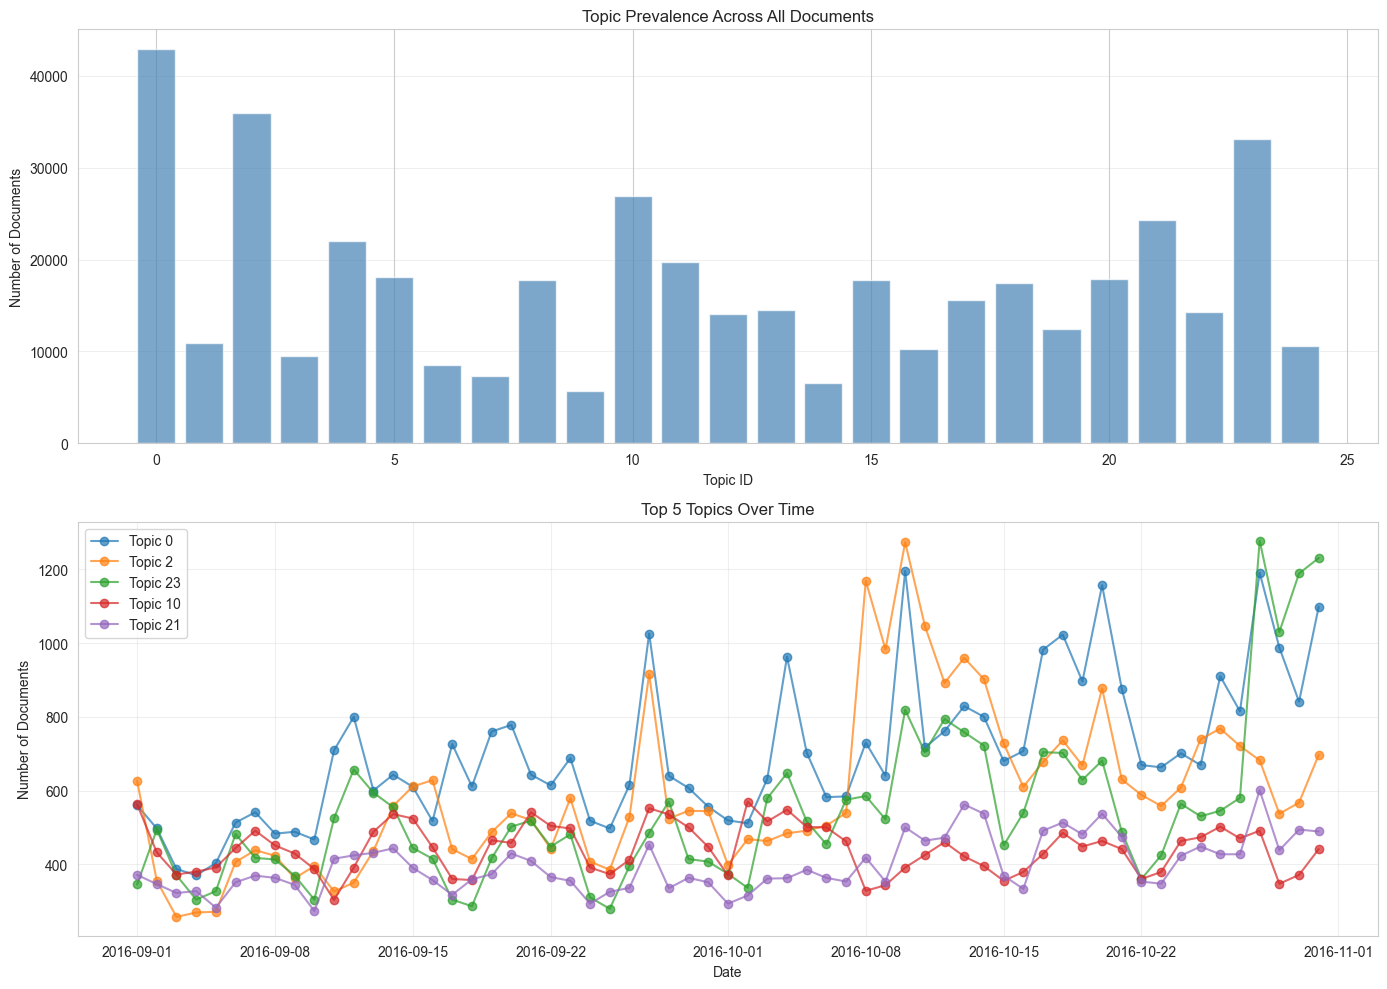

✓ Saved plot: topic_distribution.png


In [29]:
# Plot topic distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Topic prevalence
topic_counts = thread_docs['dominant_topic'].value_counts().sort_index()
axes[0].bar(topic_counts.index, topic_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Topic ID')
axes[0].set_ylabel('Number of Documents')
axes[0].set_title('Topic Prevalence Across All Documents')
axes[0].grid(axis='y', alpha=0.3)

# Topic distribution over time (top 5 topics)
top_5_topics = topic_counts.nlargest(5).index
for topic_id in top_5_topics:
    topic_data = topic_time[topic_time['dominant_topic'] == topic_id]
    axes[1].plot(pd.to_datetime(topic_data['date_only']), 
                 topic_data['count'], 
                 marker='o', 
                 label=f'Topic {topic_id}',
                 alpha=0.7)

axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Documents')
axes[1].set_title('Top 5 Topics Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / 'topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved plot: topic_distribution.png")

## 7. Topic Distribution by Subreddit

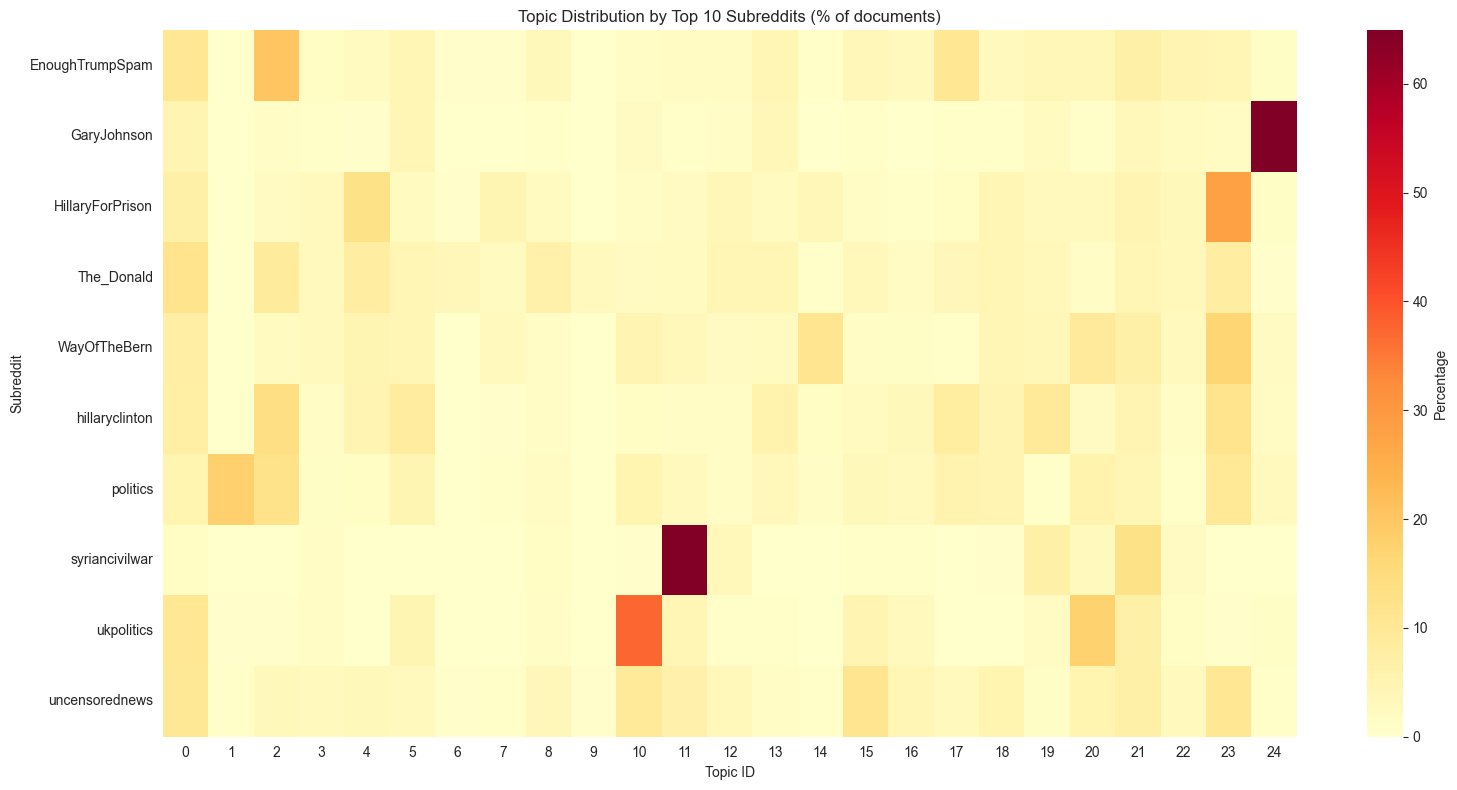

✓ Saved plot: topic_subreddit_heatmap.png


In [30]:
# Get top subreddits
top_subreddits = thread_docs['subreddit'].value_counts().head(10).index

# Topic distribution for top subreddits
subreddit_topics = thread_docs[thread_docs['subreddit'].isin(top_subreddits)].groupby(
    ['subreddit', 'dominant_topic']
).size().reset_index(name='count')

# Create pivot table for heatmap
pivot = subreddit_topics.pivot(index='subreddit', columns='dominant_topic', values='count').fillna(0)

# Normalize by subreddit (percentage)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_pct, cmap='YlOrRd', annot=False, fmt='.1f', cbar_kws={'label': 'Percentage'})
plt.title('Topic Distribution by Top 10 Subreddits (% of documents)')
plt.xlabel('Topic ID')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.savefig(output_path / 'topic_subreddit_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved plot: topic_subreddit_heatmap.png")

## 8. Save Model and Results

In [31]:
# Save document-topic distributions
doc_topics_df = pd.DataFrame(
    doc_topic_dist,
    columns=[f'topic_{i}' for i in range(N_TOPICS)]
)
doc_topics_df['submission_id'] = thread_docs['submission_id'].values

# Reorder columns (submission_id first)
cols = ['submission_id'] + [f'topic_{i}' for i in range(N_TOPICS)]
doc_topics_df = doc_topics_df[cols]

# Save
output_file = output_path / 'document_topic_distributions.parquet'
write_parquet(doc_topics_df, output_file)
print(f"✓ Saved document-topic distributions: {output_file}")
print(f"  Shape: {doc_topics_df.shape}")

✓ Wrote 433,973 rows to document_topic_distributions.parquet (53.1 MB)
✓ Saved document-topic distributions: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/document_topic_distributions.parquet
  Shape: (433973, 26)


In [32]:
# Save topic summaries
topic_summaries_df = pd.DataFrame(topic_summaries)
topic_output = output_path / 'topic_summaries.parquet'
write_parquet(topic_summaries_df, topic_output)
print(f"✓ Saved topic summaries: {topic_output}")

✓ Wrote 25 rows to topic_summaries.parquet (0.0 MB)
✓ Saved topic summaries: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/topic_summaries.parquet


In [33]:
# Save updated thread documents with topic assignments
thread_output = output_path / 'thread_pseudodocs_with_topics.parquet'
write_parquet(thread_docs, thread_output)
print(f"✓ Saved thread documents with topics: {thread_output}")
print(f"  Shape: {thread_docs.shape}")

✓ Wrote 433,973 rows to thread_pseudodocs_with_topics.parquet (1119.0 MB)
✓ Saved thread documents with topics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/thread_pseudodocs_with_topics.parquet
  Shape: (433973, 16)


## 9. Model Metadata

In [34]:
# Create model metadata
model_metadata = {
    'notebook': '15_reddit_stm_fit',
    'timestamp': datetime.now().isoformat(),
    'strategy': {
        'k_selection': 'fixed',
        'k_value': N_TOPICS,
        'justification': 'Political science best practices (Roberts 2014, Chang 2009, Grimmer & Stewart 2013)',
        'documentation': 'docs/topic_modeling_strategy.md'
    },
    'model': {
        'algorithm': 'NMF',
        'n_topics': N_TOPICS,
        'random_state': RANDOM_STATE,
        'max_iter': MAX_ITER,
        'n_iter': int(topic_model.model.n_iter_),
        'reconstruction_error': float(topic_model.model.reconstruction_err_)
    },
    'vectorizer': {
        'type': 'TfidfVectorizer',
        'max_df': MAX_DF,
        'min_df': MIN_DF,
        'max_features': MAX_FEATURES,
        'ngram_range': (1, 2),
        'vocabulary_size': len(topic_model.vectorizer.get_feature_names_out())
    },
    'data': {
        'n_documents': len(thread_docs),
        'matrix_shape': [len(thread_docs), len(topic_model.vectorizer.get_feature_names_out())],
        'n_topics': N_TOPICS
    },
    'results': {
        'mean_dominant_topic_weight': float(dominant_topic_weights.mean()),
        'median_dominant_topic_weight': float(np.median(dominant_topic_weights)),
        'documents_per_topic': {int(k): int(v) for k, v in thread_docs['dominant_topic'].value_counts().to_dict().items()}
    }
}

# Save metadata
metadata_file = output_path / 'topic_model_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"\nAlgorithm: {model_metadata['model']['algorithm']}")
print(f"Topics: {model_metadata['model']['n_topics']} (fixed K per strategy doc)")
print(f"Documents: {model_metadata['data']['n_documents']:,}")
print(f"Vocabulary: {model_metadata['vectorizer']['vocabulary_size']:,}")
print(f"Iterations: {model_metadata['model']['n_iter']}")
print(f"Reconstruction error: {model_metadata['model']['reconstruction_error']:.2f}")
print(f"\nMean dominant topic weight: {model_metadata['results']['mean_dominant_topic_weight']:.3f}")
print(f"Median dominant topic weight: {model_metadata['results']['median_dominant_topic_weight']:.3f}")
print(f"\nStrategy: {model_metadata['strategy']['justification']}")
print(f"\nMetadata saved to: {metadata_file}")

MODEL SUMMARY

Algorithm: NMF
Topics: 25 (fixed K per strategy doc)
Documents: 433,973
Vocabulary: 5,000
Iterations: 167
Reconstruction error: 614.33

Mean dominant topic weight: 0.427
Median dominant topic weight: 0.390

Strategy: Political science best practices (Roberts 2014, Chang 2009, Grimmer & Stewart 2013)

Metadata saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/topic_model_metadata.json
